In [79]:
%matplotlib notebook
import ijroi
import os
import math
import numpy as np
from scipy import stats
import pandas as pd
from matplotlib import pyplot as plt
from openpyxl import load_workbook
import trackpy as tp
import utils

TRACKS_PATH = 'WT 0-30min_channels_20_obcol.xlsx'
NUCLEUS_PATH = 'Results from C1-WT 0-30min-1 in µm per sec.csv'
IS_TRACKMATE = True

def get_writer(path):
    book = load_workbook(path)
    writer = pd.ExcelWriter(path, engine='openpyxl')
    writer.book = book
    writer.sheets = dict((ws.title, ws) for ws in book.worksheets)    
    return writer

def write_slopes_to_file(path, slopes, sheetname):
    slope_df = pd.DataFrame(slopes)
    slope_df.columns = ['particle', 'slope']
    writer = get_writer(path)
    slope_df.to_excel(writer, sheet_name=sheetname, startcol=8, index=False)
    writer.save()

def write_tracks_to_file(path, tracks, sheetname):
    writer = get_writer(path)
    tracks.to_excel(writer, sheet_name=sheetname, index=False)
    writer.save() 

def read_tracks_from_file(path):
    if path.endswith('xlsx'):
        sheets = ['red', 'green']
        tracks = {}
        for sheet in sheets:
            sheetname = '{} tracks'.format(sheet)
            try:
                tracks[sheet] = pd.read_excel(path, sheetname=sheetname)
            except:
                print('no tracks in file - now running tracking')
                data = pd.read_excel(path, sheetname=sheet)
                tracks[sheet] = utils.redo_tracking(data)
        return tracks
    else:
        raise ValueError("Input data must be in Excel format")
        
def linear_regress(data, log=True, clip=None, r2=0.8, **kwargs):
    """Fit a 1st order polynomial by doing first order polynomial fit."""
    ys = pd.DataFrame(data)
    values = pd.DataFrame(index=['slope', 'intercept', 'r2', 'good'])
    good = False
    fits = {}
    for col in ys:
        if clip:
            y = ys[col].dropna()
            limit = np.arange(1,np.min(((1+clip),len(y.index))))
            y = ys.loc[limit,[col]][col]
            x = pd.Series(y.index.values, index=y.index, dtype=np.float64)
        else:
            y = ys[col].dropna()
            x = pd.Series(y.index.values, index=y.index, dtype=np.float64)
        if log:
            slope, intercept, r, p, stderr = \
                    stats.linregress(np.log(x), np.log(y))
            if r**2 > r2:
                good = True
            values[col] = [slope, np.exp(intercept), r**2, good]
            fits[col] = x.apply(lambda x: np.exp(intercept)*x**slope)
        else:
            slope, intercept, r, p, stderr = \
                    stats.linregress(x, y)
            if r**2 > r2:
                good = True
            values[col] = [slope, intercept, r**2, good]
            fits[col] = x.apply(lambda x: intercept*x**slope)
    values = values.T
    fits = pd.concat(fits, axis=1)
    return (values,fits)        
        
def rate_of_change_distance(traj, r2=0.8):

    slope = []
    for tid, t in traj.groupby('particle'):
        t_indexed = t.set_index(['frame'], drop=False)
        nan_array = np.empty((t_indexed['frame'].max(), len(t_indexed.columns)))
        nan_array[:] = np.nan
        tnan = pd.DataFrame(nan_array, index=range(0, t_indexed['frame'].max()))
        tnan.columns = t.columns
        t_filled = t_indexed.combine_first(tnan).fillna(method='bfill')

        dfits = linear_regress(t_filled['distance'].values, log=False, r2=r2)
        if dfits[0]['good'].any() == True:
            slope.append(dfits[0]['slope'].values[0])
        else:
            slope.append(np.nan)
            
    f = range(0, len(slope))
    return zip(f, slope)

In [3]:
if IS_TRACKMATE:
    # import the nucleus centroids from TrackMate CSV
    data = pd.read_csv(NUCLEUS_PATH)
    nucleus = data[['X', 'Y']]
    nucleus.columns = ['x', 'y']
    nucleus.index += 1
    nucleus.index.name = 'frame'
else:
    # import the nucleus centroids from ImageJ rois
    fdir = 'rois'
    rois = []
    for filename in sorted(os.listdir(fdir)):
        if 'roi'in filename:
            fpath = os.path.join(fdir, filename)
            with open(fpath, "rb") as f:
                roi = ijroi.read_roi(f)
                rois.append(roi[0])

    nucleus = pd.DataFrame(np.cumsum(np.diff(np.array(rois), axis=0), axis=0))
    nucleus.columns = ['y', 'x']
    nucleus.index += 1
    nucleus.index.name = 'frame'
    
# plot the nucleus centroids
t = xrange(0, nucleus.shape[0])
plt.figure()
plt.plot(nucleus['x'], nucleus['y'], 'rx')
plt.show()

plt.figure()
plt.plot(t, nucleus['x'], 'r')
plt.plot(t, nucleus['y'], 'b')
plt.show()

         y     x
frame           
1      4.0   4.0
2      6.0   5.0
3      4.0   5.0
4      5.0   6.0
5      2.0  13.0


<IPython.core.display.Javascript object>


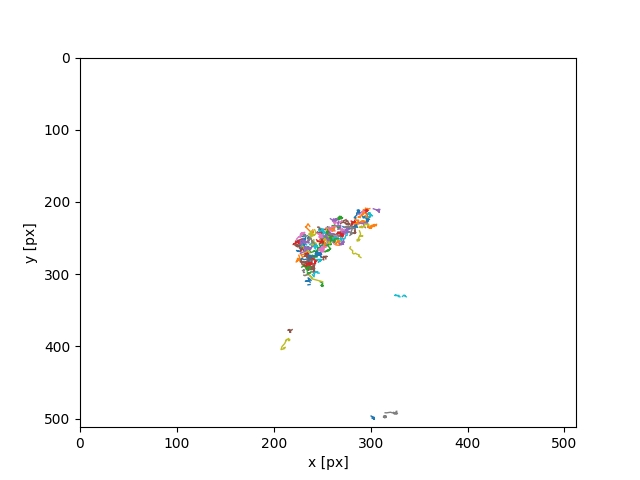

<IPython.core.display.Javascript object>


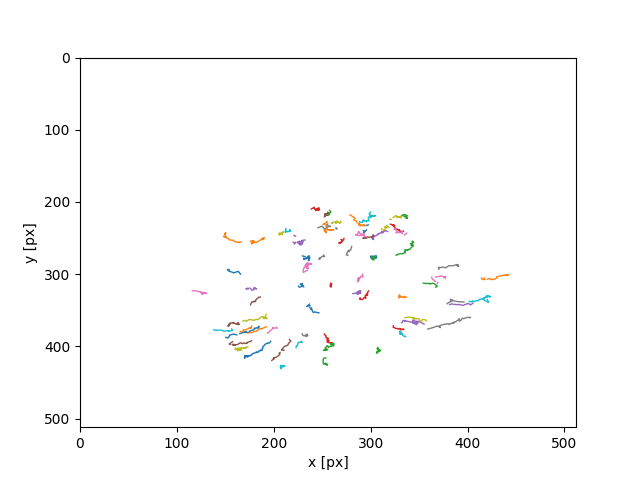

(512, 0)

In [39]:
# read the tracks from Excel file - define TRACKS_PATH above
tracks = read_tracks_from_file(TRACKS_PATH)

plt.figure()
ax1 = tp.plot_traj(tracks['red'])
ax1.set_xlim([0, 512])
ax1.set_ylim([512, 0])
plt.figure()
ax2 = tp.plot_traj(tracks['green'])
ax2.set_xlim([0, 512])
ax2.set_ylim([512, 0])

<IPython.core.display.Javascript object>


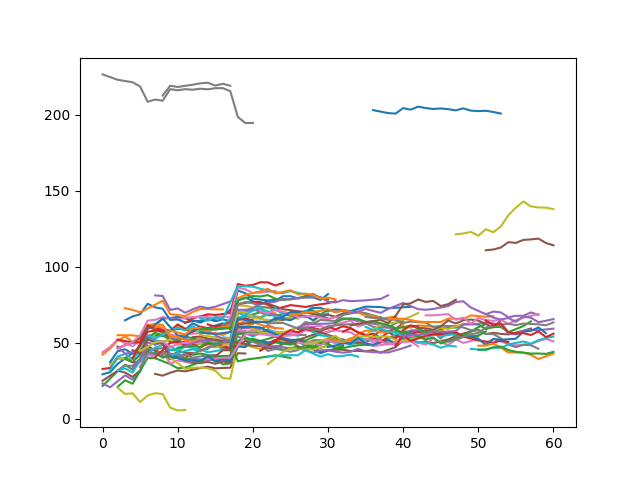

<IPython.core.display.Javascript object>


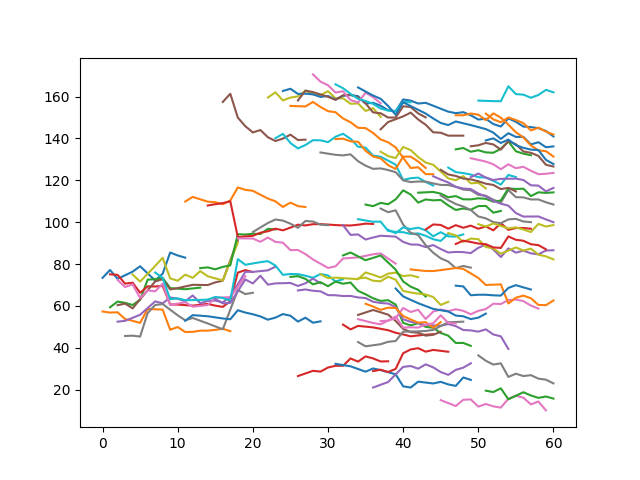

In [80]:
# calculate the distance to the nucleus for each track
# this will save the tracks back to file
def distance(x1, y1, x2, y2):
    return math.sqrt((x2 - x1)**2 + (y2 - y1)**2)

for traj_key, traj in tracks.iteritems():
    track_dist = []
    for tid, track in traj.groupby('particle'):
        dist = []
        for nid, node in track.iterrows():
            frame = node['frame']
            nucleus_x = nucleus['x'].iloc[int(frame)].item()
            nucleus_y = nucleus['y'].iloc[int(frame)].item()
            node_x = node['x'].item()
            node_y = node['y'].item()
            track_dist.append(distance(node_x, node_y, nucleus_x, nucleus_y))

    try:
        traj.insert(len(traj.columns), 'distance', track_dist)
    except:
        pass
    
    slopes = rate_of_change_distance(traj, r2=0.5)

    sheetname = '{} tracks'.format(traj_key)
    write_tracks_to_file(TRACKS_PATH, traj, sheetname)
    write_slopes_to_file(TRACKS_PATH, slopes, sheetname)

plt.figure()
for tid, track in tracks['red'].groupby('particle'):
    plt.plot(track['frame'], track['distance'])
plt.show()

plt.figure()
for tid, track in tracks['green'].groupby('particle'):
    plt.plot(track['frame'], track['distance'])
plt.show()